In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
from datetime import date
import calendar

In [2]:
# importe les données dans un dataframe
birth_df0 = pd.read_csv("birth.csv", sep=",")

# Nettoyage des données

**1. Elimination des naissances dont les données liées à la date ne sont pas renseignées**

In [3]:
print("Nombre total de lignes :", birth_df0.index.size)
print("Nombre de non nul par colonne :",birth_df0.count()) 

# Remarque : "count()" compte seulement les valeurs renseignées de chaque colonne contrairement à
# .size, qui compte tout

Nombre total de lignes : 15547
Nombre de non nul par colonne : year      15547
month     15547
day       15067
gender    15547
births    15547
dtype: int64


En comptant les éléments par colonne on s'aperçoit que seuls certains jours ne sont pas renseignés.

Il faut éliminer les lignes correspondantes :

In [4]:
print("Nbe de lignes, avant nettoyage :" , birth_df0.index.size)

# élimination des lignes dont l'année, le mois ou le jour n'est pas renseigné
birth_df1 = birth_df0.dropna()

#index des lignes éliminées
temp = np.sort(np.array(list(set(birth_df0.index) - set(birth_df1.index))))

# nbe de lignes après triage
print("Nbe de lignes, après nettoyage :", np.array(birth_df1.index).size)
print("Nbe de lignes éliminées :", temp.size)

# affichage des trois premières cellules éliminées
birth_df0.loc[temp[0:3]]

Nbe de lignes, avant nettoyage : 15547
Nbe de lignes, après nettoyage : 15067
Nbe de lignes éliminées : 480


,year,month,day,gender,births
15067,1989,1,NaN,F,156749
15068,1989,1,NaN,M,164052
15069,1989,2,NaN,F,146710


Certaines lignes comportent des jours non compris entre 1 et 31 (jours égaux à 99). On peut les filtrer de la manière suivante :
    
NB : cette étape c'est pas strictement nécessaire puisqu'elle est comprise dans l'étape suivante.

In [5]:
print("Nbe de lignes, avant nettoyage :" , np.array(birth_df1.index).size)

# on garde seulement les lignes dont les jours sont compris entre 1 et 31
cond_d = pd.Series([birth_df1.day.values[i] in range (1,32) for i in range(len(birth_df1.day))], \
                   index = birth_df1.day.index)

birth_df2 = birth_df1.where(cond_d).dropna()

#index des lignes éliminées
temp = np.sort(np.array(list(set(birth_df1.index) - set(birth_df2.index))))

# nbe de lignes après triage
print("Nbe de lignes, après nettoyage :", np.array(birth_df2.index).size)
print("Nbe de lignes éliminées :", temp.size)
               
# affichage des trois premières cellules éliminées
birth_df1.loc[temp[0:3]]

Nbe de lignes, avant nettoyage : 15067
Nbe de lignes, après nettoyage : 14717
Nbe de lignes éliminées : 350


,year,month,day,gender,births
62,1969,1,99.0,F,26
63,1969,1,99.0,M,38
126,1969,2,99.0,F,42


Création d'une nouvelle colonne qui agrège les données jour, mois et année pour en faire des dates

In [6]:
# Crée une dataframe temporaire contenant les données pour former les dates
date_df = pd.DataFrame({'year':birth_df2.year.values.astype(int),\
                        'month':birth_df2.month.values.astype(int),\
                        'day':birth_df2.day.values.astype(int)}, index = birth_df2.index)



# ajout d'une nouvelle colonne indiquant la date au format timestamp
birth_df3 = birth_df2.drop(columns = ["gender", "month", "day"], inplace=False) # retrait des colonnes inutiles 
birth_df3["date"] = pd.Series(pd.to_datetime(date_df,errors='coerce')) # ajout de la nouvelle colonne

# affichage des trois premières cellules de la nouvelle dataframe
birth_df3.tail(3)

,year,births,date
15064,1988.0,6095.0,1988-12-30
15065,1988.0,4435.0,1988-12-31
15066,1988.0,4698.0,1988-12-31


La méthode '.to_datetime' transforme automatiquement toute date non valide en NaT (not a timestamp), qu'on peut ensuite filtrer facilement grace à la méthode '.dropna' :

In [7]:
print("Nbe de lignes, avant nettoyage :" , birth_df3.index.size)

# Elimination des lignes dont l'année, le mois et le jour forment une date qui n'existe pas
# (notamment les 29 janvier d'années non bissextiles)
birth_df4 = birth_df3.dropna(subset=['date'])

#index des lignes éliminées
temp = np.sort(np.array(list(set(birth_df3.index) - set(birth_df4.index))))

# nbe de lignes après triage
print("Nbe de lignes, après nettoyage :", birth_df4.index.size)
print("Nbe de lignes éliminées :", temp.size)

# affichage des trois premières cellules éliminées
birth_df3.loc[temp[0:3]]

Nbe de lignes, avant nettoyage : 14717
Nbe de lignes, après nettoyage : 14610
Nbe de lignes éliminées : 107


,year,births,date
120,1969.0,50.0,NaT
121,1969.0,16.0,NaT
122,1969.0,24.0,NaT


In [8]:
# ajout d'une nouvelle colonne indiquant le numéro (utile par la suite pour l'ordre de l'affichage des jours dans les graphes) et le nom du jour de naissance

ind = birth_df4.index
nb_day_week = [birth_df4.date.loc[i].weekday() for i in ind]
day_week = [calendar.day_name[birth_df4.date.loc[i].weekday()] for i in ind]
nb_day_week_ser = pd.Series(nb_day_week,index = ind)
day_week_ser = pd.Series(day_week,index = ind)
new_df = pd.DataFrame({'nb_day_week': nb_day_week_ser, 'day_week': day_week_ser})

birth_df5 = pd.concat([birth_df4,new_df], axis=1)

birth_df5.tail(3)

,year,births,date,nb_day_week,day_week
15064,1988.0,6095.0,1988-12-30,4,Friday
15065,1988.0,4435.0,1988-12-31,5,Saturday
15066,1988.0,4698.0,1988-12-31,5,Saturday


# Affichage des données

__0. Pré-visualisation globale__

Créons deux tableaux pertinents pour les tracés ultérieurs...

In [9]:
# Tableau dynamique du nombre de naissances en fonction du jour de la semaine pour les trois décennies
masque = pd.cut(birth_df5['year'], np.array([1960,1970,1980,1990]))

birth_pt0 = birth_df5.pivot_table('births', index = [masque], columns = ['nb_day_week', 'day_week'], aggfunc = "sum")
#dftest = birth_df3.reindex(birth_pt['day_week'].sort_values(by=2012, ascending=False).index)
birth_pt0

nb_day_week,0,1,2,3,4,5,6
day_week,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
year,,,,,,,
"(1960, 1970]",1072594.0,1123488.0,1090704.0,1066176.0,1078904.0,982794.0,918524.0
"(1970, 1980]",4882617.0,5074669.0,4941667.0,4885094.0,4982204.0,4358362.0,4137862.0
"(1980, 1990]",4416584.0,4615642.0,4501015.0,4483536.0,4532122.0,3750348.0,3590602.0


In [10]:
# tableau dynamique du nombre de naissances par année
birth_pt1 = birth_df5.pivot_table('births', index = 'year', aggfunc = "sum")
birth_pt1.head(3)

,births
year,
1969.0,3598578.0
1970.0,3734606.0
1971.0,3563074.0


... et relevons les dates de début et de fin de la plage sur laquelle porte les données :

In [11]:
print("Première date :", np.min(birth_df5['date']) )
print("Dernière date :", np.max(birth_df5['date']) )

Première date : 1969-01-01 00:00:00
Dernière date : 1988-12-31 00:00:00


On remarque que les trois catégories choisies (années 60, 70 et 80) ne sont pas vraiment judicieuses puisque les données valides ne portent en fait que sur des années entre le 01/01/1968 et le 31/12/1988.

__1. Affichage global__

Affichons maintenant les données pour chaque année, ainsi que la répartition selon les jours de la semaine :

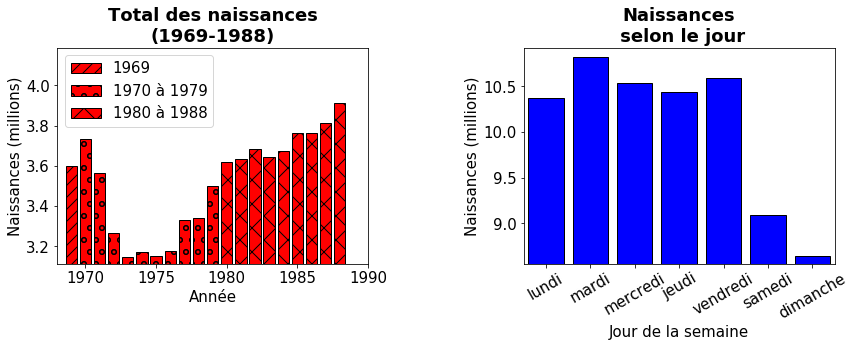

In [16]:
fig = plt.figure(figsize=(18,3))
plt.rcParams.update({'font.size': 15})
plt.grid(color='grey', linestyle='dotted')

# Pré-visualisation des données en fonction des années

plot1 = plt.subplot(1, 2, 1)

x1 = list(birth_pt1.index) # np.array(birth_pt1.index)
y1 = np.array(birth_pt1.births.values)
x1_1 = x1[0:x1.index(1970)]
y1_1 = y1[0:x1.index(1970)]
x1_2 = x1[x1.index(1970):x1.index(1980)]
y1_2 = y1[x1.index(1970):x1.index(1980)]
x1_3 = x1[x1.index(1980):]
y1_3 = y1[x1.index(1980):]
y1_min = np.min(y1)*0.99/1e6
y1_max = np.max(y1)*1.07/1e6

plot1.bar(x1_1, y1_1/1e6, color = 'red', edgecolor='k', hatch='//', label='1969')
plot1.bar(x1_2, y1_2/1e6, color = 'red', edgecolor='k', hatch='o', label='1970 à 1979')
plot1.bar(x1_3, y1_3/1e6, color = 'red', edgecolor='k', hatch='x', label='1980 à 1988')
ax1 = plt.title("Total des naissances\n(1969-1988)",fontweight="bold")
plt.xlabel("Année")
plt.ylabel("Naissances (millions)")
plt.axis([1968 ,1990 , y1_min, y1_max])
plt.legend()

# Valeur absolue globale du nombre de naissances pour chaque jour de la semaine

plot2 = plt.subplot(1, 2, 2)

y2 = birth_pt0.iloc[0].values + birth_pt0.iloc[1].values + birth_pt0.iloc[2].values
x2 = range(len(y2))
ind = ['lundi', 'mardi', 'mercredi', 'jeudi', 'vendredi', 'samedi', 'dimanche']
y2_min = np.min(y2)*0.99/1e6
y2_max = np.max(y2)*1.01/1e6

plot2.bar(x2, y2/1e6, color = 'blue', edgecolor='k', label='naissances' )
ax2 = plt.title("Naissances\n selon le jour",fontweight="bold")
plt.xlabel("Jour de la semaine")
plt.ylabel("Naissances (millions)")
plt.axis([-0.5, 6.5, y2_min, y2_max])
plt.xticks(range(7), ind, rotation=30)

plt.gcf().subplots_adjust(left = 0.1, bottom = 0.2, right = 0.7, top = 1.2, wspace = 0.5, hspace = 0.2)

plt.show()



On remarque de plus que l'années 1988, bien que comportant des données allant jusqu'au 31/12/1988 compte beaucoup moins de naissances que les autres.

__2. Courbes du nombre de naissances pour les décennies 60, 70 et 80.__

Forts des constatation précédentes, on trace : 
* le nombre total de naissances selon le jour de la semaine pour chaque décennie (données demandées),
* le pourcentage de naissances selon le jour de la semaine pour chaque décennie,
* le pourcentage moyen de naissances selon le jour de la semaine sur tout l'échantillon (plus pertinent peut-être pour connaître le pourcentage de cartes à prévoir par la suite pour chaque jour .

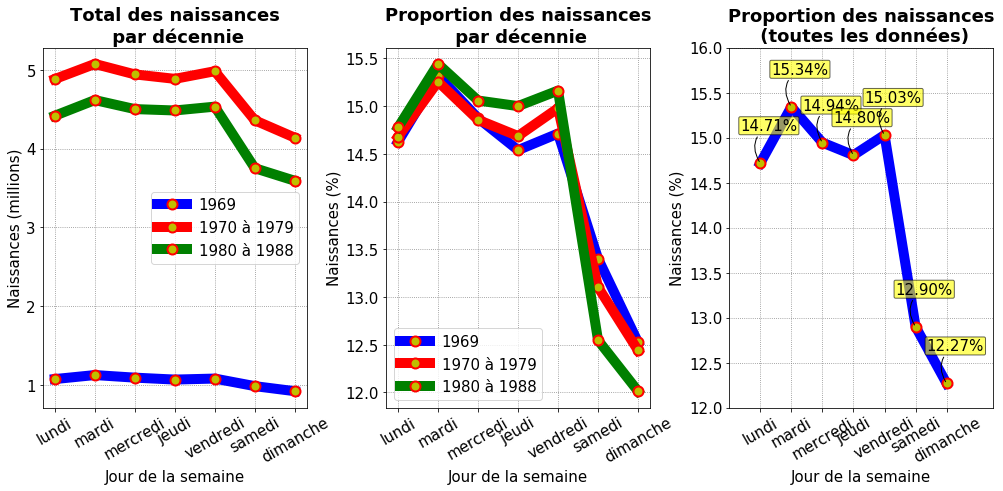

In [17]:
## Nombre de naissance pour chaque jour de la semaine pour les décénnies 60, 70 et 80

y_60 = birth_pt0.iloc[0].values
y_70 = birth_pt0.iloc[1].values
y_80 = birth_pt0.iloc[2].values

fig = plt.figure(figsize=(22,5))

# Graphe 1 : Nombre de naissances selon le jour de la semaine pour les trois décennies

plot1 = plt.subplot(1, 3, 1)

plot1.plot(range(len(y_60)),(y_60)/1000000, \
         'o', c='blue', lw=10, ls='solid', \
         ms = 10, mfc = 'y', mec='red',  mew = 2, \
         label='1969',zorder = 5)
plot1.plot(range(len(y_70)),(y_70)/1000000, \
         'o', c='red', lw=10, ls='solid', \
         ms = 10, mfc = 'y', mec='red',  mew = 2, \
         label='1970 à 1979',zorder = 10)
plot1.plot(range(len(y_80)),(y_80)/1000000, \
         'o', c='green', lw=10, ls='solid', \
         ms = 10, mfc = 'y', mec='red',  mew = 2, \
         label='1980 à 1988',zorder = 15)

plt.title("Total des naissances\n par décennie",fontweight="bold")
ax1 = plt.xlabel("Jour de la semaine")
plt.ylabel("Naissances (millions)")
plt.rcParams.update({'font.size': 15})
plt.grid(color='grey', linestyle='dotted')
plt.xticks(range(7), ind, rotation=30)
plt.legend(loc='best')

## Graphe 2 : Pourcentage des naissances pour chaque jour

plot2 = plt.subplot(1, 3, 2)

plot2.plot(range(len(y_60)),(y_60*100/np.sum(y_60)), \
         'o', c='blue', lw=10, ls='solid', \
         ms = 10, mfc = 'y', mec='red',  mew = 2, \
         label='1969',zorder = 5)
plot2.plot(range(len(y_70)),(y_70*100/np.sum(y_70)), \
         'o', c='red', lw=10, ls='solid', \
         ms = 10, mfc = 'y', mec='red',  mew = 2, \
         label='1970 à 1979',zorder = 10)
plot2.plot(range(len(y_80)),(y_80*100/np.sum(y_80)), \
         'o', c='green', lw=10, ls='solid', \
         ms = 10, mfc = 'y', mec='red',  mew = 2, \
         label='1980 à 1988',zorder = 15)
ax2 = plt.title("Proportion des naissances\n par décennie",fontweight="bold")
plt.xlabel("Jour de la semaine")
plt.ylabel("Naissances (%)")
plt.rcParams.update({'font.size': 15})
#plt.axis([-0.5, 6.5, 0.135, 0.155])
plt.grid(color='grey', linestyle='dotted')
plt.xticks(range(7), ind, rotation=30)
plt.legend(loc='best')

## Graphe 3 : Pourcentage des naissances pour chaque jour

plot3 = plt.subplot(1, 3, 3)


my_x = range(len(y2))
my_y = y2*100/np.sum(y1)

plot3 = plt.plot(my_x, my_y, \
         'o', c='blue', lw=10, ls='solid', \
         ms = 10, mfc = 'y', mec='red',  mew = 2)
ax3 = plt.title("Proportion des naissances\n (toutes les données)",fontweight="bold")
plt.xlabel("Jour de la semaine")
plt.ylabel("Naissances (%)")
plt.rcParams.update({'font.size': 15})
plt.axis([-1, 7.5, 12, 16])
plt.grid(color='grey', linestyle='dotted')
plt.xticks(range(7), ind, rotation=30)

labels = ['{:2.2f}%'.format(my_y[i]) for i in range(len(my_y))]
for label, my_x, my_y in zip(labels, my_x, my_y):
    plt.annotate(label, xy=(my_x, my_y), xytext=(-20, 30),
        textcoords='offset points', ha='left', va='bottom',
        bbox=dict(boxstyle='round,pad=0.1', fc='yellow', alpha=0.6),
        arrowprops=dict(arrowstyle = '-', connectionstyle='arc3,rad=0.5'))

plt.gcf().subplots_adjust(left = 0.1, bottom = 0.2, right = 0.7, top = 1.2, wspace = 0.3, hspace = 0)

plt.show()

Traçons pour finir un tableau reprenant les pourcentages à prévoir de cartes de voeux pour chaque jour de la semaine :

In [18]:
# Crée une dataframe temporaire contenant les données à afficher
stat_df = pd.DataFrame({'Jour': ind ,'Proportion': np.array(y2/np.sum(y2))})
stat_df

,Jour,Proportion
0,lundi,0.147148
1,mardi,0.153419
2,mercredi,0.149440
3,jeudi,0.148042
4,vendredi,0.150289
5,samedi,0.128984
6,dimanche,0.122678
